# PROJECT: Machine Learning

Download the dataset from this link:
https://www.crowdflower.com/wp-content/uploads/2016/03/GOP_REL_ONLY.csv
The dataset contains tweets from a political debate in America in August 2015. Train a classifier to predict the sentiment (positive, negative, neutral) of the tweets.

# General idea

following the pipeline of "data preprocessing - feature selecting - experiment realizing",make predictions on the category of tweets.<p>
<font color=black size=5 face="times new roman">1.Data preprocessing:<p>
    <font color=black size=4.6 face="times new roman">1) Cleaning<br />
    <font color=black size=3 face="times new roman">       • Remove URLs<br />
        • Remove usernames (mentions)<br />
        • Remove tweets with Not Available text<br />
        • Remove special characters<br />
        • Remove numbers<br />
        • Remove "RT"s<br />
        •Change it into lower case<p>
    <font color=black size=4.8 face="times new roman">2) Text processing<br />
       <font color=black size=3 face="times new roman"> • Tokenize<br />
        • Stemming<br />
        • Stemming<p>
    <font color=black size=4.9 face="times new roman">3) Build word list for Bag-of-Words<br />
        <br />
<font color=black size=5 face="times new roman">2.feature selecting: Add some other features which may influence the sentiments.<br />
    <br />
<font color=black size=5 face="times new roman">3.experiment realizing: experiment on models including<br />
        <font color=black size=4 face="times new roman">• Naive Bayes<br />
        • Random Forest<br />
        • XGboost<br />

## Import  Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import pandas as pd

import re as regex
import numpy as np


from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly
import cufflinks as cf
import re

## Import the Data

In [2]:
train_data = pd.read_csv('GOP_REL_ONLY.csv',encoding="unicode_escape")
#test_data = pd.read_csv('data/test.csv')
train_data = train_data[train_data['sentiment:confidence'] > 0.6] 
train_data = train_data[['sentiment','text']]



In [3]:
train_data.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12209 entries, 0 to 13870
Data columns (total 2 columns):
sentiment    12209 non-null object
text         12209 non-null object
dtypes: object(2)
memory usage: 286.1+ KB


## Data visualization

## Distribution of target class

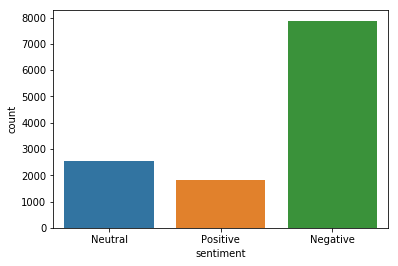

In [5]:
sns.countplot(x='sentiment',data=train_data)

# Preprocessing of Data

<font color=black size=4 face="times new roman">Data in the reality may be incomplete,counfusing,and performs in various forms. 
This provides the computer challenges to resolve it during the classification.<br />
<mark style=background-color:yellow>Preprocessing </mark> transform raw data into an understandable format.<br /> 
Data preprocessing is a proven method of resolving such issues. <br />
Data preprocessing prepares raw data for further processing.<br />
The aim of the preprocessing is finally to get a <mark style=background-color:yellow>'bag of words'</mark> to represent the appearence of the words.

## Data Cleaning

<font color=black size=4 face="times new roman">Data Cleaning process makes data "clean",which basically including the removal of "special cases".

<font color=black size=4 face="times new roman">the function of Cleaning:<br />
            • Remove URLs<br />
            • Remove usernames (mentions)<br />
            • Remove tweets with Not Available text<br />
            • Remove special characters<br />
            • Remove numbers<br />
            • Remove "RT"s<br />
            • Change it into lower case<br />


In [6]:
def clean_tweets(tweet):
    
    # remove URL
    tweet = re.sub(r"http\S+", "", tweet)
    
    # Remove usernames
    tweet = re.sub(r"@[^\s]+[\s]?",'',tweet)
    
    # remove special characters 
    tweet = re.sub('[^ a-zA-Z0-9]', '', tweet)
    
    # remove Numbers
    tweet = re.sub('[0-9]', '', tweet)
    
    # remove RT
    tweet = re.sub('RT', '', tweet) 
    
    tweet = tweet.lower()
    
    return tweet



In [7]:
# Apply function to Tweet column

train_data['clean'] = train_data['text'].apply(clean_tweets)

In [8]:
train_data.head()

,sentiment,text,clean
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,how did everyone feel about the climate chang...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,didnt catch the full gopdebate last night her...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,no mention of tamir rice and the gopdebate wa...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,that carly fiorina is trending hours after h...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,gopdebate w delivered the highest ratings in ...


## Tokenization, Stemming and Lemmatization

• Tokenize:
    Tokenization makes the full sentence into seperate words.
• Stemming:
    Stemming focuses on the stem of the words and can avoid spelling mistakes.
    e.g: funnnnny → funny
• Lemmatizing:
    Lemmatization restores the words.
    e.g: is/are/was → be

In [10]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer=WordNetLemmatizer()
ps = PorterStemmer()

In [11]:
def tokenize(text):
    return word_tokenize(text)

def stemming(words):
    stem_words = []
    for w in words:
        w = ps.stem(w)
        stem_words.append(w)
    
    return stem_words

from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def lemmatize_sentence(sentence):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(word_tokenize(sentence)):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res

def stemming_sentence(text):
    '''
    eliminate plurals and redundancy of words (ie thank, thanks)
    '''
    ps = PorterStemmer()
    text = tokenize(text)
    text = ' '.join(ps.stem(word) for word in text)
    return(text)



In [12]:
# apply tokenize function
train_data['text_split'] = train_data['clean'].apply(tokenize)

In [14]:
# apply steming function

train_data['text_stemmed'] = train_data['text_split'].apply(stemming)
train_data['text_stemmed_sentence'] = train_data['clean'].apply(stemming_sentence)

# apply lemmatizeing function

train_data['text_lemmatized'] = train_data['text_stemmed_sentence'].apply(lemmatize_sentence)


In [15]:
train_data.head()

,sentiment,text,clean,text_split,text_stemmed,text_stemmed_sentence,text_lemmatized
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,how did everyone feel about the climate chang...,"[how, did, everyone, feel, about, the, climate...","[how, did, everyon, feel, about, the, climat, ...",how did everyon feel about the climat chang qu...,"[how, do, everyon, feel, about, the, climat, c..."
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,didnt catch the full gopdebate last night her...,"[didnt, catch, the, full, gopdebate, last, nig...","[didnt, catch, the, full, gopdeb, last, night,...",didnt catch the full gopdeb last night here ar...,"[didnt, catch, the, full, gopdeb, last, night,..."
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,no mention of tamir rice and the gopdebate wa...,"[no, mention, of, tamir, rice, and, the, gopde...","[no, mention, of, tamir, rice, and, the, gopde...",no mention of tamir rice and the gopdeb wa hel...,"[no, mention, of, tamir, rice, and, the, gopde..."
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,that carly fiorina is trending hours after h...,"[that, carly, fiorina, is, trending, hours, af...","[that, carli, fiorina, is, trend, hour, after,...",that carli fiorina is trend hour after her deb...,"[that, carli, fiorina, be, trend, hour, after,..."
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,gopdebate w delivered the highest ratings in ...,"[gopdebate, w, delivered, the, highest, rating...","[gopdeb, w, deliv, the, highest, rate, in, the...",gopdeb w deliv the highest rate in the histori...,"[gopdeb, w, deliv, the, high, rate, in, the, h..."


## Wordlist

The wordlist (dictionary) is build by simple count of occurences 
of every unique word across all of the training dataset.

In [16]:
words = Counter()
for idx in train_data.index:
    words.update(train_data.loc[idx, "text_lemmatized"])

words.most_common(5)

[('gopdeb', 12302), ('the', 7873), ('be', 5249), ('to', 4196), ('a', 3385)]

In [17]:
stopwords=nltk.corpus.stopwords.words("english")

In [18]:
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

[('gopdeb', 12302),
 ('trump', 1631),
 ('fox', 1206),
 ('not', 1158),
 ('thi', 1104)]

In [19]:
def word_list(processed_data):
    #print(processed_data)
    min_occurrences=3
    max_occurences=13000
    stopwords=nltk.corpus.stopwords.words("english")
    whitelist = ["n't","not"]
    wordlist = []
    
    whitelist = whitelist if whitelist is None else whitelist
    #print(whitelist)
    '''
    import os
    if os.path.isfile("wordlist.csv"):
        word_df = pd.read_csv("wordlist.csv")
        word_df = word_df[word_df["occurrences"] > min_occurrences]
        wordlist = list(word_df.loc[:, "word"])
        #return
    '''
    words = Counter()
    for idx in processed_data.index:
        words.update(processed_data.loc[idx, "text_lemmatized"])

    for idx, stop_word in enumerate(stopwords):
        if stop_word not in whitelist:
            del words[stop_word]
    #print(words)

    word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                 "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                           columns=["word", "occurrences"])
    #print(word_df)
    word_df.to_csv("wordlist.csv", index_label="idx")
    wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]
    #print(wordlist)

In [20]:
word_list(train_data)

In [21]:
words = pd.read_csv("wordlist.csv")

## Bag of Words

In [23]:
import os

In [24]:
wordlist= []
if os.path.isfile("wordlist.csv"):
    word_df = pd.read_csv("wordlist.csv")
    word_df = word_df[word_df["occurrences"] > 10]
    wordlist = list(word_df.loc[:, "word"])

label_column = ["label"]
columns = label_column + list(map(lambda w: w + "_bow",wordlist))

labels = []
rows = []
for idx in train_data.index:
    current_row = []
    
    # add label
    current_label = train_data.loc[idx, "sentiment"]
    labels.append(current_label)
    current_row.append(current_label)

    # add bag-of-words
    tokens = set(train_data.loc[idx, "text_lemmatized"])
    for _, word in enumerate(wordlist):
        current_row.append(1 if word in tokens else 0)

    rows.append(current_row)

data_model = pd.DataFrame(rows, columns=columns)
data_labels = pd.Series(labels)


bow = data_model

## Classification

In [25]:
import random
seed = 888
random.seed(seed)


In [26]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    log("")
    log("---------------------------------------------------------")
    log("Testing " + str(type(classifier).__name__))
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    log("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    log("Predicting time {0}s".format(time() - now))

    # Calculate Accuracy, Precision, recall
    
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    
    log("=================== Results ===================")
    log("            Negative     Neutral     Positive")
    log("F1       " + str(f1))
    log("Precision" + str(precision))
    log("Recall   " + str(recall))
    log("Accuracy " + str(accuracy))
    log("===============================================")

    return precision, recall, accuracy, f1

def log(x):
    #can be used to write to log file
    print(x)


<font color=black size=4 face="times new roman">To evaluate the performance of the classifier, we use 'Accuracy, Precision, recall'.
TP: prediction = Possitive, true
TN: prediction = Negative，true
FP: prediction = Possitive, false
FN: prediction = Negative，false

Acurracy = (TP+TN)/(TP+TN+FP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1 = 2*(Precision*Recall)/(Precision+Recall)

## Experiment on Naive Bayes with no added-feature 

In [27]:
from sklearn.naive_bayes import BernoulliNB
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:], bow['label'], test_size=0.3)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, BernoulliNB())


---------------------------------------------------------
Testing BernoulliNB
Learing time 0.5157170295715332s
Predicting time 0.17186188697814941s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.77864924 0.47274882 0.51335878]
Precision[0.79741187 0.44039735 0.52131783]
Recall   [0.76074926 0.51023018 0.5056391 ]
Accuracy 0.6702156702156702


In [28]:
def cv(classifier, X_train, y_train):
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    now = time()
    log("Crossvalidating " + classifier_name + "...")
    accuracy = [cross_val_score(classifier, X_train, y_train, cv=8, n_jobs=-1)]
    log("Crosvalidation completed in {0}s".format(time() - now))
    log("Accuracy: " + str(accuracy[0]))
    log("Average accuracy: " + str(np.array(accuracy[0]).mean()))
    log("===============================================")
    return accuracy

## experiments on Random Forest with no added-feature

In [29]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:], bow['label'], test_size=0.3)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, RandomForestClassifier(random_state=seed,n_estimators=403,n_jobs=-1))



---------------------------------------------------------
Testing RandomForestClassifier
Learing time 27.90682053565979s
Predicting time 0.8341944217681885s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.80444268 0.42366691 0.50710383]
Precision[0.75334324 0.47697368 0.63911846]
Recall   [0.86297872 0.38107753 0.42028986]
Accuracy 0.6961506961506961


In [30]:
rf_acc = cv(RandomForestClassifier(n_estimators=403,n_jobs=-1, random_state=seed),bow.iloc[:, 1:], data_model['label'])

Crossvalidating RandomForestClassifier...
Crosvalidation completed in 307.5116033554077s
Accuracy: [0.67931937 0.63892529 0.66906946 0.65137615 0.57798165 0.69200524
 0.6965924  0.68327869]
Average accuracy: 0.6610685321055921


## experiments on XGboost with no added-feature

In [31]:
from xgboost import XGBClassifier as XGBoostClassifier

In [32]:
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:],data_model['label'] , test_size=0.3)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, XGBoostClassifier(seed=seed))


---------------------------------------------------------
Testing XGBClassifier
Learing time 127.53679752349854s
Predicting time 0.42290425300598145s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.80054645 0.07898089 0.31240876]
Precision[0.67124857 0.75609756 0.82307692]
Recall   [0.99153976 0.04166667 0.19279279]
Accuracy 0.6775866775866776


## Add Extra Features

To run the extra feature function we have to oad the data again because we have already removed the special charactrs and numbers.

In [33]:
train_data = pd.read_csv('GOP_REL_ONLY.csv',encoding="unicode_escape")
#train_data = pd.read_csv('data/train.csv')
#test_data = pd.read_csv('data/test.csv')

#train_data.rename(columns={'sentiment': 'emotion'}, inplace=True)
#test_data.rename(columns={'Category': 'emotion'}, inplace=True)


train_data = train_data[train_data['sentiment:confidence'] > 0.6] 
train_data = train_data[['sentiment','text']]

#test_data = test_data[test_data['emotion'] != 'Tweet']

In [34]:
def add_extra_feature(df, tweet_column):
    
    # Print Number of Exclamation
    #length_of_excl = (len(re.findall(r'!', string)))
    df['number_of_exclamation'] = tweet_column.apply(lambda x: (len(re.findall(r'!', x))))
    
    # Number of ?
    #length_of_questionmark = (len(re.findall(r'?', string)))
    df['number_of_questionmark'] = tweet_column.apply(lambda x: (len(re.findall(r'[?]', x))))
    
    # Number of #
    df['number_of_hashtag'] = tweet_column.apply(lambda x: (len(re.findall(r'#', x))))
    
    # Number of @
    df['number_of_mention'] = tweet_column.apply(lambda x: (len(re.findall(r'@', x))))
    
    # Number of Quotes
    df['number_of_quotes'] = tweet_column.apply(lambda x: (len(re.findall(r"'", x))))

    # Number if underscore
    df['number_of_underscore'] = tweet_column.apply(lambda x: (len(re.findall(r'_', x))))
    
    
    #print((txt.split(" "), row))
    #print(row.split())

In [35]:
# pass the train_data into add_extra_feature function
add_extra_feature(train_data, train_data["text"])
#print(train_data)

## ADD EMOTICONS

Emoticons in a tweet also matter, so we will find the emoticons in a users tweet.And add the number of positive and negative emoticons as two seperate features into the dataset.
Unfortunatly, the emoticions cannot be shown in the output correctly. One possible reason might be the encoding of the file is not utf-8. When reading the csv file, the parameter encoding is set to 'escape unicode'.

In [36]:
## Emoticon Detector

class EmoticonDetector:
    emoticons = {}

    def __init__(self, emoticon_file="emoticons.txt"):
        from pathlib import Path
        content = Path(emoticon_file).read_text()
        positive = True
        for line in content.split("\n"):
            if "positive" in line.lower():
                positive = True
                continue
            elif "negative" in line.lower():
                positive = False
                continue

            self.emoticons[line] = positive

    def is_positive(self, emoticon):
        if emoticon in self.emoticons:
            return self.emoticons[emoticon]
        return False

    def is_emoticon(self, to_check):
        return to_check in self.emoticons

In [37]:
ed = EmoticonDetector()

In [38]:
processed_data = train_data.copy()

def add_column(column_name, column_content):
    processed_data.loc[:, column_name] = pd.Series(column_content, index=processed_data.index)

def count_by_lambda(expression, word_array):
    return len(list(filter(expression, word_array)))

add_column("split", map(lambda txt: txt.split(" "), processed_data["text"]))

positive_emo = list(
    map(lambda txt: count_by_lambda(lambda word: ed.is_emoticon(word) and ed.is_positive(word), txt),
        processed_data["split"]))
add_column("number_of_positive_emo", positive_emo)

negative_emo = list(map(
    lambda txt: count_by_lambda(lambda word: ed.is_emoticon(word) and not ed.is_positive(word), txt),
    processed_data["split"]))

add_column("number_of_negative_emo", negative_emo)

In [39]:
train_data['number_of_positive_emo'] = positive_emo
train_data['number_of_negative_emo'] = negative_emo

# a=train_data['number_of_positive_emo']
# b=a[a>0]
# print(b)




## WHY EXTRA FEATURES

The distributions of the extra feature of the data set are showned below.<br />
These graphs can show how the extra features represent the sentiments to some extent.<p>

Feature name Explanation:<p>
Number of uppercase: Uppercase words help to identify the negative or positive emotions of a user<br />
Number of !: Exclamation marks are likely to increase the strength of opinion<br />
Number of ?: Can be used to identify neutral tweets<br />
Number of positive emoticons: Use of positive emoticon may imply the positive sentiment<br />
Number of negative emoticons: Use of negative emoticon may imply the negative sentiment<br />
Number of quotations Same as above<br />
Number of mentions: People mention other people mostly to share something good<br />
Number of hashtags: For experiment purpose<br />

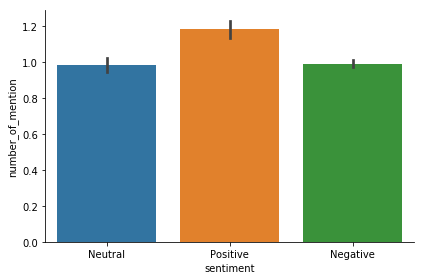

In [40]:
sns.barplot(x='sentiment', y='number_of_mention', data=train_data)
sns.despine()
plt.tight_layout()

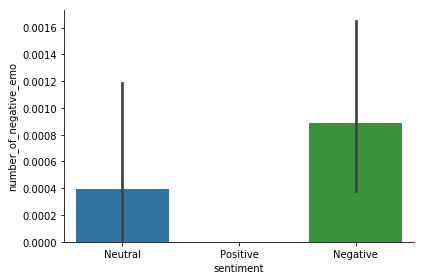

In [41]:
sns.barplot(x='sentiment', y='number_of_negative_emo', data=train_data)
sns.despine()
plt.tight_layout()

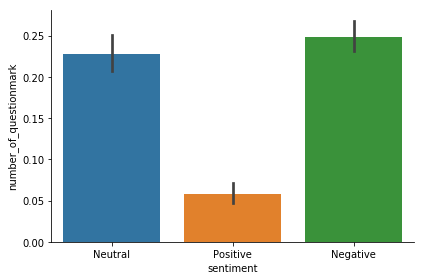

In [42]:
sns.barplot(x='sentiment', y='number_of_questionmark', data=train_data)
sns.despine()
plt.tight_layout()

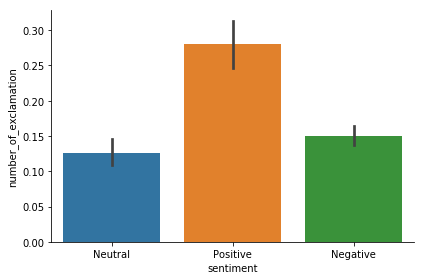

In [43]:
sns.barplot(x='sentiment', y='number_of_exclamation', data=train_data)
sns.despine()
plt.tight_layout()

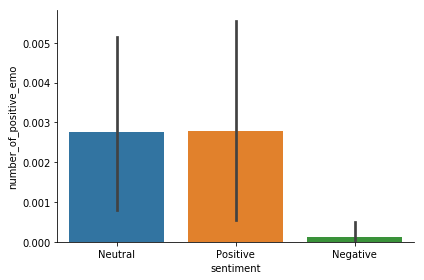

In [44]:
sns.barplot(x='sentiment', y='number_of_positive_emo', data=train_data)
sns.despine()
plt.tight_layout()

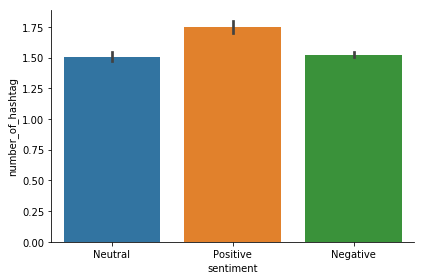

In [45]:
sns.barplot(x='sentiment', y='number_of_hashtag', data=train_data)
sns.despine()
plt.tight_layout()

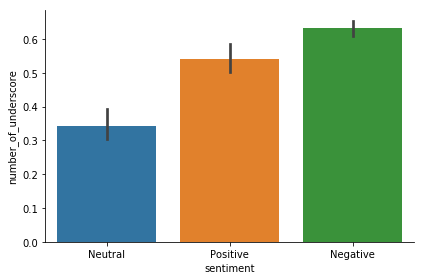

In [46]:
sns.barplot(x='sentiment', y='number_of_underscore', data=train_data)
sns.despine()
plt.tight_layout()

## Preapre training data for model

In [47]:
train_data.head()

,sentiment,text,number_of_exclamation,number_of_questionmark,number_of_hashtag,number_of_mention,number_of_quotes,number_of_underscore,number_of_positive_emo,number_of_negative_emo
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,0,1,1,1,0,0,0,0
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,0,0,2,1,2,1,0,0
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,0,1,1,1,0,0,0,0
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,0,0,1,1,1,1,0,0
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,0,0,2,2,0,1,0,0


In [48]:
# apply the clean tweet function
train_data['tweet'] = train_data['text'].apply(clean_tweets)

In [49]:
## Tokenize data
train_data['text_split'] = train_data['tweet'].apply(tokenize)

train_data['text_stemmed'] = train_data['text_split'].apply(stemming)

train_data['text_stemmed_sentence'] = train_data['tweet'].apply(stemming_sentence)
train_data['lemmatized'] = train_data['text_stemmed_sentence'].apply(lemmatize_sentence)


In [50]:
train_data.head()

,sentiment,text,number_of_exclamation,number_of_questionmark,number_of_hashtag,number_of_mention,number_of_quotes,number_of_underscore,number_of_positive_emo,number_of_negative_emo,tweet,text_split,text_stemmed,text_stemmed_sentence,lemmatized
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,0,1,1,1,0,0,0,0,how did everyone feel about the climate chang...,"[how, did, everyone, feel, about, the, climate...","[how, did, everyon, feel, about, the, climat, ...",how did everyon feel about the climat chang qu...,"[how, do, everyon, feel, about, the, climat, c..."
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,0,0,2,1,2,1,0,0,didnt catch the full gopdebate last night her...,"[didnt, catch, the, full, gopdebate, last, nig...","[didnt, catch, the, full, gopdeb, last, night,...",didnt catch the full gopdeb last night here ar...,"[didnt, catch, the, full, gopdeb, last, night,..."
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,0,1,1,1,0,0,0,0,no mention of tamir rice and the gopdebate wa...,"[no, mention, of, tamir, rice, and, the, gopde...","[no, mention, of, tamir, rice, and, the, gopde...",no mention of tamir rice and the gopdeb wa hel...,"[no, mention, of, tamir, rice, and, the, gopde..."
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,0,0,1,1,1,1,0,0,that carly fiorina is trending hours after h...,"[that, carly, fiorina, is, trending, hours, af...","[that, carli, fiorina, is, trend, hour, after,...",that carli fiorina is trend hour after her deb...,"[that, carli, fiorina, be, trend, hour, after,..."
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,0,0,2,2,0,1,0,0,gopdebate w delivered the highest ratings in ...,"[gopdebate, w, delivered, the, highest, rating...","[gopdeb, w, deliv, the, highest, rate, in, the...",gopdeb w deliv the highest rate in the histori...,"[gopdeb, w, deliv, the, high, rate, in, the, h..."


In [51]:
## BAG OF WORDS
wordlist= []
if os.path.isfile("wordlist.csv"):
    word_df = pd.read_csv("wordlist.csv")
    word_df = word_df[word_df["occurrences"] > 3]
    wordlist = list(word_df.loc[:, "word"])

label_column = ["label"]
columns = label_column + list(map(lambda w: w + "_bow",wordlist))
labels = []
rows = []
for idx in train_data.index:
    current_row = []
        # add label
    current_label = train_data.loc[idx, "sentiment"]
    labels.append(current_label)
    current_row.append(current_label)

    # add bag-of-words
    tokens = set(train_data.loc[idx, "lemmatized"])
    for _, word in enumerate(wordlist):
        current_row.append(1 if word in tokens else 0)

    rows.append(current_row)

data_model = pd.DataFrame(rows, columns=columns)
data_labels = pd.Series(labels)



In [52]:
dat1 = train_data
dat2 = data_model


dat1 = dat1.reset_index(drop=True)
dat2 = dat2.reset_index(drop=True)

data_model = dat1.join(dat2)

In [53]:
train_data.columns

Index(['sentiment', 'text', 'number_of_exclamation', 'number_of_questionmark',
       'number_of_hashtag', 'number_of_mention', 'number_of_quotes',
       'number_of_underscore', 'number_of_positive_emo',
       'number_of_negative_emo', 'tweet', 'text_split', 'text_stemmed',
       'text_stemmed_sentence', 'lemmatized'],
      dtype='object')

In [54]:
## Drop the columns in data_model
# data_model = data_model.drop(columns=['sentiment', 'text','text_split', 'text_stemmed','tweet',
#        'text_stemmed_sentence', 'lemmatized','number_of_hashtag', 'number_of_mention', 'number_of_quotes',
#        'number_of_underscore'], axis=1)
data_model = data_model.drop(columns=['sentiment', 'text','text_split', 'text_stemmed','tweet',
       'text_stemmed_sentence', 'lemmatized'], axis=1)


In [55]:
data_model.head()

,number_of_exclamation,number_of_questionmark,number_of_hashtag,number_of_mention,number_of_quotes,number_of_underscore,number_of_positive_emo,number_of_negative_emo,label,gopdeb_bow,...,solidifi_bow,constitutiongopdeb_bow,hoe_bow,matur_bow,store_bow,chuteto_bow,politiciansboo_bow,ambival_bow,jebspeak_bow,labotomi_bow
0,0,1,1,1,0,0,0,0,Neutral,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,1,2,1,0,0,Positive,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,Neutral,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,0,0,Positive,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,2,0,1,0,0,Positive,1,...,0,0,0,0,0,0,0,0,0,0


## Experiment 1: Added feature + Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(data_model.drop(columns='label',axis=1),data_model['label'] , test_size=0.3)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, RandomForestClassifier(random_state=seed,n_estimators=403,n_jobs=-1))



---------------------------------------------------------
Testing RandomForestClassifier
Learing time 41.97654414176941s
Predicting time 0.8436894416809082s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.81915493 0.37510513 0.51477833]
Precision[0.74819897 0.5        0.69205298]
Recall   [0.90497925 0.30013459 0.40980392]
Accuracy 0.7133497133497133


In [57]:
rf_acc = cv(RandomForestClassifier(n_estimators=403,n_jobs=-1, random_state=seed),data_model.drop(columns='label',axis=1), data_model['label'])

Crossvalidating RandomForestClassifier...
Crosvalidation completed in 415.563595533371s
Accuracy: [0.68717277 0.67824377 0.67365662 0.66644823 0.58060288 0.67562254
 0.68676278 0.69639344]
Average accuracy: 0.6681128807251708


## Experiment 2: Added Feature + XGBoost

In [58]:
from xgboost import XGBClassifier as XGBoostClassifier

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_model.drop(columns='label',axis=1),data_model['label'] , test_size=0.3)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, XGBoostClassifier(seed=seed))


---------------------------------------------------------
Testing XGBClassifier
Learing time 292.3040671348572s
Predicting time 0.8282027244567871s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.80689061 0.0952381  0.37606838]
Precision[0.68459515 0.55714286 0.76744186]
Recall   [0.98238255 0.05206943 0.2490566 ]
Accuracy 0.6860496860496861


## Experiment 3: Added Feature + Naive Bayes

In [60]:
X_train, X_test, y_train, y_test = train_test_split(data_model.drop(columns='label',axis=1),data_model['label'] , test_size=0.3)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, BernoulliNB())


---------------------------------------------------------
Testing BernoulliNB
Learing time 1.094020128250122s
Predicting time 0.4218466281890869s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.79001721 0.49484536 0.54421769]
Precision[0.80845443 0.4573991  0.56      ]
Recall   [0.77240219 0.53896962 0.52930057]
Accuracy 0.689052689052689


## Test Data

From the above experiments we can conclude that Random Forest gives better result than other models.As a result, if there is any seperate Test dataset, the Test Data will be classified on Random Forest following the pipeline before.
preprocessing - doing experiments on Random Forest.

# Conclusion

<font color=black size=4 face="times new roman">The work presented in this document specifies an approach for <mark style=background-color:yellow>sentiment analysis on Twitter data. </mark><br />
To unseal the sentiment, we extracted the relevant data from the texts, preprocessed the data including <mark style=background-color:yellow><font color=black size=4 face="times new roman">cleaning <font> </mark>,<mark style=background-color:yellow><font color=black size=4 face="times new roman">tokenizing</mark>,<mark style=background-color:yellow><font color=black size=4 face="times new roman">stemming<font></mark>, <mark style=background-color:yellow><font color=black size=4 face="times new roman">lemmatizating<font></mark>, <mark style=background-color:yellow><font color=black size=4 face="times new roman">remove the stop words<font></mark>.<br />
And then we added the features for the next process of modeling and implementing experiments.<br />
<font color=black size=4 face="times new roman">The experiment basically carried out several models to classify the emtion of the tweets. From the performance of the several experiment, Random Forest with added-features gave out a better performance than others, which has a accuracy of 0.71. <p>






# problems

<font color=black size=4 face="times new roman">However, several problems still exsist.<br />
·Simple bag-of-words was definitely not enough to obtain satisfying results, thus a lot of additional features were created basing on common sense (number of emoticons, exclamation marks, number of question mark etc).<br />
  The graphs of the distributions of the Added features seem to suggest those feature may have influence on the classification. However, the performances of the one with added-features are almost the same or even worse.The possible reason may be that the dataset included highly skewed data (a relatively smaller number of positive cases), the difference will be probably in the order of a few percents. Solutions need to be find out to improve the skewed data,such as changing the weight.<p>
·Furthermore, the emoticions might need to be take into consideration seperately. <br />
  The emoticions cannot be shown in the output correctly. One possible reason might be the encoding of the file is not utf-8. When reading the csv file, the parameter encoding is set to 'escape unicode'.Then the emoticions cannot be showned correctly. Due to the limitation of time and the unreadable display of the emoticons, the way used in the demo of "AlineSentimentAnalysis"(https://github.com/SangitaG/AirlineSentimentAnalysis) is still not implement in this experiment.


## Reference
·https://github.com/abdulfatir/twitter-sentiment-analysis <br />
·https://github.com/SangitaG/AirlineSentimentAnalysis <br />
·https://github.com/ajayshewale/Sentiment-Analysis-of-Text-Data-Tweets- <br />
